In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import os
import pandas as pd
import numpy as np
from glob import glob

import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential

from keras import layers
from keras import Model


from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
from keras import optimizers
from keras import backend as K

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau



from sklearn.metrics import classification_report
from keras.optimizers import SGD


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


from keras.applications.inception_resnet_v2 import InceptionResNetV2


Using TensorFlow backend.


In [2]:
train_path = 'train/'
valid_path = 'test/'



num_train_samples = 1000 # len(df_train)
num_val_samples = 216    # len(df_val)
train_batch_size = 10
val_batch_size = 10

image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)




train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (image_size,image_size),
                                                 batch_size = train_batch_size)


test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (image_size,image_size),
                                            batch_size = val_batch_size)

Found 1000 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


In [3]:
pre_trained_model = InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

W1114 00:33:01.265109  2324 deprecation_wrapper.py:119] From C:\Users\S\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1114 00:33:01.268061  2324 deprecation_wrapper.py:119] From C:\Users\S\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1114 00:33:01.277037  2324 deprecation_wrapper.py:119] From C:\Users\S\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1114 00:33:01.312936  2324 deprecation_wrapper.py:119] From C:\Users\S\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1114 00:33:01.313932  2324 deprecation_wrapper.py:119] From C:\Users\S\

In [4]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output


x = layers.GlobalMaxPooling2D()(last_output)

x = layers.Dense(512, activation='relu')(x)

x = layers.BatchNormalization(axis=-1)(x)

x = layers.Dropout(0.5)(x)

x = layers.Dense(2, activation='softmax')(x)


model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

W1114 00:33:32.392551  2324 deprecation.py:506] From C:\Users\S\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1114 00:33:32.460373  2324 deprecation_wrapper.py:119] From C:\Users\S\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



last layer output shape: (None, 5, 5, 1536)


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

activation_15 (Activation)      (None, 25, 25, 32)   0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 25, 25, 64)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
block35_1_mixed (Concatenate)   (None, 25, 25, 128)  0           activation_13[0][0]              
                                                                 activation_15[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
block35_1_conv (Conv2D)         (None, 25, 25, 320)  41280       block35_1_mixed[0][0]            
__________________________________________________________________________________________________
block35_1 

In [6]:
print(test_set.class_indices)

{'mama': 0, 'nonmama': 1}


In [7]:
class_weights={
    0: 1.0, # mama
    1: 1.0, # nonmama
}

In [8]:
history = model.fit_generator(training_set,
                    steps_per_epoch = 100,
                    epochs = 5,
                    validation_data = test_set,
                    validation_steps = val_steps,
                    class_weight=class_weights)

W1114 00:33:32.977956  2324 deprecation.py:323] From C:\Users\S\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
100/100 [==============================] - 196s 2s/step - loss: 0.7945 - acc: 0.6910 - val_loss: 0.7594 - val_acc: 0.7176
Epoch 2/5
100/100 [==============================] - 107s 1s/step - loss: 0.4513 - acc: 0.8140 - val_loss: 0.8307 - val_acc: 0.8102
Epoch 3/5
100/100 [==============================] - 100s 1s/step - loss: 0.2399 - acc: 0.9210 - val_loss: 1.1485 - val_acc: 0.8843
Epoch 4/5
100/100 [==============================] - 98s 984ms/step - loss: 0.2598 - acc: 0.9010 - val_loss: 0.3134 - val_acc: 0.9398
Epoch 5/5
100/100 [==============================] - 98s 984ms/step - loss: 0.1911 - acc: 0.9290 - val_loss: 0.0909 - val_acc: 0.9769


In [9]:
model.save('model_ResNetV2-2.h5')

In [10]:
test_batches = test_datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)


predictions = model.predict_generator(test_batches, steps=216, verbose=1)


Found 216 images belonging to 2 classes.
216/216 [==============================] - 30s 138ms/step


In [11]:
y_pred = np.argmax(predictions, axis=-1)
len(y_pred)

216

In [12]:
sum(y_pred==test_batches.classes)

211

In [13]:
len(test_batches.classes)

216

In [14]:
sum(y_pred==test_batches.classes)/len(y_pred)

0.9768518518518519

In [15]:
test_labels = test_batches.classes

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm

array([[ 56,   2],
       [  3, 155]], dtype=int64)

In [16]:
target_names = ['mama','nonmama']
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        mama       0.95      0.97      0.96        58
     nonmama       0.99      0.98      0.98       158

   micro avg       0.98      0.98      0.98       216
   macro avg       0.97      0.97      0.97       216
weighted avg       0.98      0.98      0.98       216



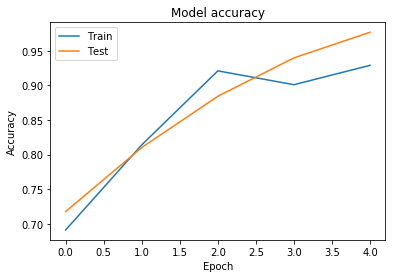

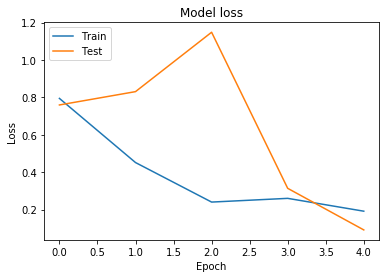

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()